In [9]:
# Libraries used
import torch
import matplotlib.pyplot as plt
from torch.autograd import grad

In [10]:
# Reload when updating utils
from sys import path
from importlib import reload
from utils import DeepONet, SNN, Model
reload(DeepONet)
reload(SNN)
reload(Model)
from utils.DeepONet import DeepONet
from utils.SNN import SNN, vRO, predict_rollout
from utils.Model import Model

In [11]:
def analytic_solution(iv, t, w=1):
    """Get analytical solution of the BVP for inital values and times"""
    p0 = iv[:,None,0] 
    q0 = iv[:,None,1] 
    p = p0 @ torch.cos(w * t).T - (q0 @ torch.sin(w * t).T) * w
    q = q0 @ torch.cos(w * t).T + (p0 @ torch.sin(w * t).T) / w
    return torch.stack((p, q), dim=-1)

def get_data(num_iv=10, num_t=10, Tmax=5):
    
    # Generate inital values
    iv = 2*torch.rand(size=(num_iv, 2), dtype=torch.float32) - 1 


    if num_t > 1:
        # Random time generation if num_t > 1
        t = Tmax * torch.rand(size=(num_t,1), dtype=torch.float32)
    else:
        # Otherwise deterministic
        t = torch.tensor([Tmax], dtype=torch.float32)[:,None]

    y = analytic_solution(iv, t).squeeze()
    X = (iv, t)
    
    return X, y

TRAIN MODEL AND PLOT LOSS HISTORY

Step 	 Train loss 	 Test loss
100 	 [7.79e-03] 	 [3.10e-02] 	 New best model!
200 	 [7.08e-04] 	 [7.48e-03] 	 New best model!
300 	 [2.78e-04] 	 [3.54e-03] 	 New best model!
400 	 [2.30e-04] 	 [2.99e-03] 	 New best model!
500 	 [2.01e-04] 	 [2.63e-03] 	 New best model!
600 	 [1.83e-04] 	 [2.27e-03] 	 New best model!
700 	 [1.49e-04] 	 [1.92e-03] 	 New best model!
800 	 [3.71e-04] 	 [1.81e-03] 	 New best model!
900 	 [1.65e-04] 	 [1.25e-03] 	 New best model!
1000 	 [8.97e-05] 	 [9.39e-04] 	 New best model!


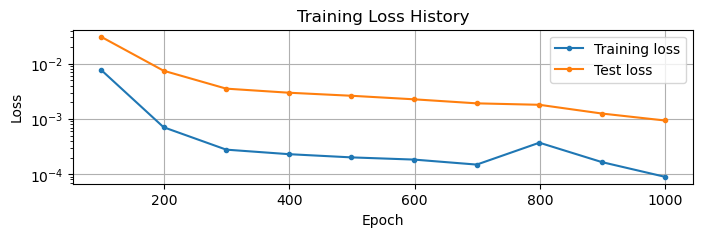

In [12]:
# Maximal time and time-step for rollouts
Tmax, h = 4, 1e-3

# Set random seed
torch.manual_seed(0)

# Whether to use rollout prediction
# This affects data going in to X
rollout = False

if rollout:
    X_train, y_train = get_data(num_iv=3, num_t=1, Tmax=h)
    X_test, y_test = get_data(num_iv=3, num_t=1, Tmax=h)
    X_train = (X_train[0][...,None,0], X_train[0][...,None,1])
    X_test = (X_test[0][...,None,0], X_test[0][...,None,1])
    #net = SNN1D(3, [10,10,10], h, activation='tanh')
    net = vRO([2, 20, 20, 20, 2], activation='htanh')

else:
    X_train, y_train = get_data(num_iv=10, num_t=10, Tmax=Tmax)
    X_test, y_test = get_data(num_iv=10, num_t=10, Tmax=Tmax)
    net = DeepONet([40, 40, 40], [40, 40, 40], dim=2, K=2, activation='tanh', scheme='QR')

model = Model(X_train, y_train, X_test, y_test, net)
model.train(iterations=1_000)
model.plot_losshistory()

PLOT ENERGY OF PREDICTIONS

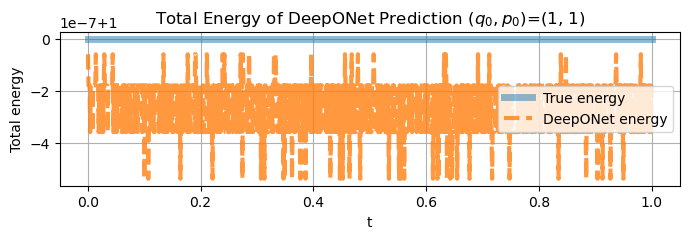

In [13]:
def plot_energy(net, q=1, p=1, Tmax=1, dpi=100):
    """Plot the energy of the system (Hamiltonian) as time progresses"""
    
    t = torch.linspace(0, Tmax, int(Tmax / h)+1, dtype=torch.float32)

    if rollout:
        one = torch.tensor([[1.]], dtype=torch.float32)
        u = predict_rollout(net, (one, -one), Tmax, h)[0,...]
                
    else:
        iv = torch.tensor([[1, -1]], dtype=torch.float32)
        u = net(iv, t[:,None])[0,...]
                
    # Energy of prediction
    E_pred = torch.linalg.norm(u, axis=-1)**2/2    
    
    # True energy
    E_true = torch.ones_like(E_pred) * (q**2 + p**2) / 2
    
    # Plot both energies
    _, ax = plt.subplots(figsize=(8, 2), dpi=dpi)
    ax.set_title(f'Total Energy of DeepONet Prediction $(q_0, p_0)$=({q}, {p})')
    ax.plot(t, E_true.detach(), alpha=0.5, linewidth=5, label='True energy')
    ax.plot(t, E_pred.detach(), '--', alpha=0.8, linewidth=3,  label='DeepONet energy')
    ax.legend()
    ax.grid(True)
    ax.set_xlabel("t")
    ax.set_ylabel("Total energy")
    plt.show()

plot_energy(net)

PLOT EXAMPLE PREDICTION

In [14]:
def plot_predictions(pred, true, t):
    """Plots predictions versus true solutions"""

    fig, axes = plt.subplots(2, 2, figsize=(20, 4), dpi=150)

    axes[0][0].set_title('Prediction')
    axes[0][1].set_title('Error')
    
    handles, labels = [], ['true', 'pred']
    
    for k in range(axes.shape[0]):
        for l in range(pred.shape[0]):
            
            line1, = axes[k][0].plot(t, true[l, :, k], alpha=0.5, linewidth=5)
            line2, = axes[k][0].plot(t, pred[l, :, k], '--', c='k')
            axes[k][1].plot(t, true[l, :, k] - pred[l, :, k], linewidth=2, c='r')
            
            axes[k][0].set_ylabel('p' if k == 0 else 'q')

            # Store handles and labels only once
            if k == 0:
                handles = [line1, line2]

        axes[k][0].grid(True)
        axes[k][1].grid(True)

    axes[k][0].set_xlabel("t")
    axes[k][1].set_xlabel("t")

    # Create a shared legend
    fig.legend(handles, labels, loc="upper center", ncol=len(labels), fontsize=10)

    plt.show()

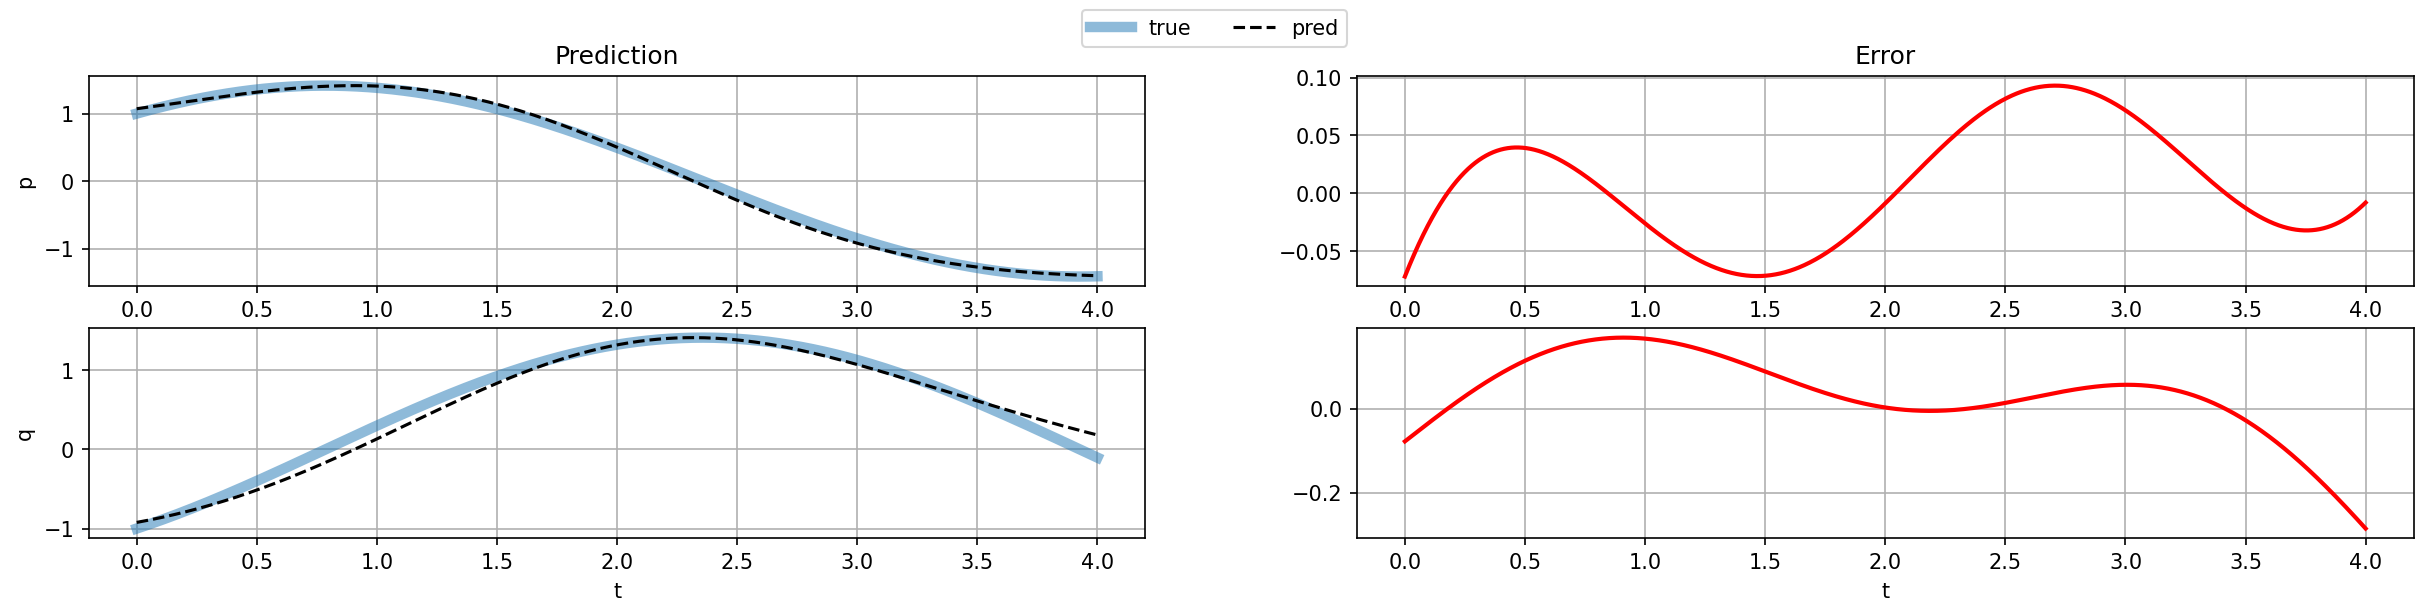

In [15]:
iv = torch.tensor([[1, -1]], dtype=torch.float32)
t = torch.linspace(0, Tmax, int(Tmax / h)+1, dtype=torch.float32)

if rollout:
    one = torch.tensor([[1.]], dtype=torch.float32)
    pred  = predict_rollout(net, (one, -one), Tmax, h).detach().numpy()
    
else:
    pred = net(iv, t[:,None]).detach().numpy()

true = analytic_solution(iv, t[:,None]).detach().numpy()   
plot_predictions(pred, true, t)
        


TEST SYMPLECTICITY

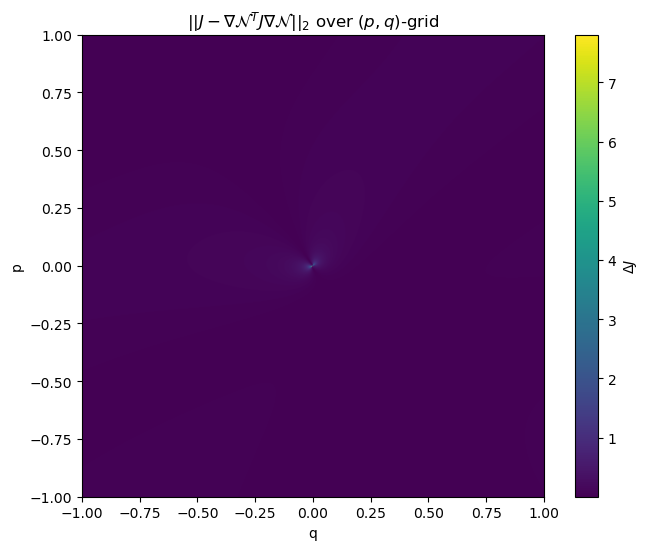

In [16]:
def plot_symplecticity(model, num_pts=100):
    """Plots how far the network is from being symplectic"""
            
    # Generate grid of inital data
    grid_points = torch.linspace(-1, 1, num_pts, requires_grad=True, dtype=torch.float32)
    mesh = torch.cartesian_prod(grid_points, grid_points)

    # Generate predictions on the grid
    if rollout:
        X = (mesh[...,None,0], mesh[...,None,1])
        u = model.net(*X)
    else: 
        u = model.net(mesh, torch.tensor([[h]]))[:,0,:]
        
    # Calculate Jacobian of predicitions
    D = torch.stack([grad(u[:,i], mesh, grad_outputs=torch.ones_like(u[:,i]), retain_graph=True)[0] for i in range(u.shape[1])], axis=-1).squeeze(1)

    # Matrix J
    J = torch.tensor([[0, 1], [-1, 0]], dtype=torch.float32)

    # Make the relevant calculation for 'delta J'
    DTJD = torch.matmul(D.transpose(1, 2), torch.matmul(J, D))
    deltaJ = torch.linalg.norm(DTJD - J, ord=2, dim=(1, 2)).numpy().reshape(num_pts, num_pts)
    
    # Plot 'delta J' on the grid    
    plt.figure(figsize=(8, 6))
    plt.imshow(deltaJ, extent=(-1, 1, -1, 1), origin='lower', cmap='viridis')
    plt.colorbar(label='$\Delta J$')
    plt.title("$||J - \\nabla \\mathcal{N}^T J \\nabla \\mathcal{N}||_2$ over $(p,q)$-grid")
    plt.xlabel('q')
    plt.ylabel('p')
    plt.show()

# Test if the net is symplectic
plot_symplecticity(model, num_pts=1000)